In [1]:
%matplotlib inline

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import torch
import torch.nn as nn
import timm
import numpy as np
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import robustbench

device = torch.device('cuda', 4)

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [3]:
def abs_normalize(x, q=None, start_dim=-3):
  s = torch.quantile(x.abs().flatten(start_dim=start_dim), q=max(q, 1-q), dim=-1, keepdim=False)
  x = 0.5 + 0.5 * x/s[(..., ) + (None,)*(-start_dim)]

  x = torch.clamp(x, 0., 1.)
  return x
  
def plot_side_by_side_normalize(*images, normalize):
  plt.figure(figsize=(20,20))
  assert len(images) == len(normalize)
  columns = len(images)
  for i, image in enumerate(images):
      plt.subplot(len(images) // columns + 1, columns, i + 1)
      image = image.detach()
      with torch.no_grad():
        if image.shape[-1] > 3:
          image = image.permute(1, 2, 0)
        if normalize[i]:
          image = abs_normalize(image, q=0.01)
        plt.imshow(image, cmap='gray')

In [4]:
from typing import Callable, Any

def get_output(module, input, output):
    return output

def get_input(module, input, output):
    return input

def get_input_output(module, input, output):
    return input, output

def get_module_input_output(module, input, output):
    return module, input, output

def register_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_bkw_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def register_bkw_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def _hook_fn_cntr(name, activation_dict, hook_fn):
    def hook(model, input, output):
        activation_dict[name] = hook_fn(model, input, output)
    return hook

In [5]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

def add_imagenet_normalization(model):
  val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

  normalize_transform = val_transform.transforms[-1]
  model = nn.Sequential(normalize_transform, model)
  return model

def load_model(path, ema=False):
    model_kwargs=dict({
            'num_classes': 1000,
            'drop_rate': 0.0,
            'drop_path_rate': 0.0,
            'drop_block_rate': None,
            'global_pool': None,
            'bn_momentum': None,
            'bn_eps': None,
    })
    if '_resnet_' in path:
      model = timm.models.create_model('resnet50', pretrained=False, **model_kwargs)
      if '_gelu' in path:
        replace_layers(model, nn.ReLU, nn.GELU())
    elif '_swinb' in path:
      model = timm.models.create_model('swin_base_patch4_window7_224', pretrained=False, **model_kwargs)
    elif '_swins' in path:
      model = timm.models.create_model('swin_small_patch4_window7_224', pretrained=False, **model_kwargs)
    ckpt = torch.load(path, map_location='cpu')
    if ema:
      if 'state_dict_ema' in ckpt:
        model.load_state_dict(ckpt['state_dict_ema'])
      else:
        return None
    else:
      model.load_state_dict(ckpt['state_dict'])

    model = add_imagenet_normalization(model)
    return model.eval().cpu()

def load_public_model(model_name):
  if model_name[0].isupper():
    return robustbench.utils.load_model(model_name, dataset='imagenet', threat_model='Linf').eval().to(device)
  else:
    if 'random' in model_name:
      return add_imagenet_normalization(timm.create_model(model_name[:-len('_random')], pretrained=False).eval()).cpu()
    else:
      return add_imagenet_normalization(timm.create_model(model_name, pretrained=True).eval()).cpu()

## Data

In [6]:
data = torch.load('analysis_data/240206_gen_imagenet_data_10k_noattack.pth', map_location='cpu')
# xs = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/inputs.pth')
# ys = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/targets.pth')
# data = {'xs':xs, 'ys':ys}

In [7]:
data.keys()

dict_keys(['xs', 'ys', 'at_outs', 'at_grads', 'gn_outs', 'gn_grads', 'sampler_indices'])

In [8]:
xs = data['xs']
ys = data['ys']

N = 10000
xs = xs[:N]
ys = ys[:N]

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

normalize_transform = val_transform.transforms[-1]

if xs.min() < 0:
  xs = xs*normalize_transform.std[None, :, None, None] + normalize_transform.mean[None, :, None, None]

sampler_indices = range(N)
ds = torch.utils.data.TensorDataset(xs, ys)

from tqdm.auto import tqdm

dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=10,
    sampler=sampler_indices,
    shuffle=False
)

def get_activations(module_name, model_path=None, model_name=None):
  if model_path:
    model = load_model(model_path)
  elif model_name:
    model = load_public_model(model_name)

  model = model.to(device)

  handle, act_dict = register_hook_fn_to_module(model, module_name, get_input_output)
  
  outs = []
  grads = []
  act_inputs = []
  act_outputs = []

  for ii, (x, y) in enumerate(tqdm(dataloader)):
      x, y = x.to(device), y.to(device)
      x.requires_grad_(True)

      # Clean at
      out = model(x)#.cpu()
      loss = torch.nn.functional.cross_entropy(out, y)
      act_input = act_dict[module_name][0][0].detach().cpu()
      act_output = act_dict[module_name][1][0].detach().cpu() if isinstance(act_dict[module_name][1], tuple) else act_dict[module_name][1].detach().cpu()
      grad_x = torch.autograd.grad(loss, x, create_graph=False, retain_graph=False)[0].detach().cpu() #.abs().sum(1, keepdim=True)
      #logit = out[torch.arange(out.size(0)), y].sum()
      #grad_x = torch.autograd.grad(logit, x, create_graph=False, retain_graph=False)[0].detach().cpu().abs().max(1, keepdim=True).values

      outs.append(out.detach().cpu())
      grads.append(grad_x)
      act_inputs.append(act_input)
      act_outputs.append(act_output)

      if ii >= 2:
        break
  
  outs = torch.cat(outs, 0)
  grads = torch.cat(grads, 0)
  act_inputs = torch.cat(act_inputs, 0)
  act_outputs = torch.cat(act_outputs, 0)
  handle.remove()

  model = model.to('cpu')

  return outs, grads, act_inputs, act_outputs

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
import random

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
noise = torch.rand(2*xs.size(0), *xs.shape[1:])
alpha = torch.rand((xs.size(0), 1, 1, 1))

def measure_local_linearity(model, dataloader, eps=4./255.):
  model.eval()
  
  lin_errs = []

  for ii, (x, y) in enumerate(tqdm(dataloader)):
      x, y = x.to(device), y.to(device)
      bs = x.size(0)
      noise_batch = noise[ii*2*bs:ii*2*bs + 2*bs].to(device)
      alpha_batch = alpha[ii*bs:ii*bs + bs].to(device)
      # print(alpha_batch.flatten(), y.flatten())

      with torch.inference_mode():
        # Get random triplet
        x_ab = x.repeat([2,1,1,1]) 
        x_ab = x_ab + eps*(2*noise_batch - 1)
        x_c = (1-alpha_batch)*x_ab[:bs] + alpha_batch*x_ab[bs:]
        alpha_batch = alpha_batch.squeeze()

        # Forward pass
        criterion = torch.nn.CrossEntropyLoss(reduction='none')
        losses = criterion(model(torch.cat((x_ab,x_c),dim=0)), y.repeat([3]))

        # Regularization term
        lin_err = torch.nn.functional.mse_loss(losses[2*bs:], (1-alpha_batch)*losses[:bs] + alpha_batch*losses[bs:2*bs], reduction='none')

        lin_errs.append(lin_err)

      # if ii >= 0:
      #   break
  
  lin_errs = torch.cat(lin_errs, 0)

  model = model.to('cpu')

  return lin_errs

In [22]:
def launch_measure_local_linearity(model_path=None, model_name=None):
  if model_path:
    model = load_model(model_path)
    print(model_path)
  elif model_name:
    model = load_public_model(model_name)
    print(model_name)

  model = model.to(device)
  model.eval()

  lin_errs = measure_local_linearity(model, dataloader)
  print(lin_errs.mean().item(), lin_errs.std().item())
  return lin_errs

In [23]:
results_dict = {}

In [24]:
def linear_stats(k):
  x = results_dict[k]
  return x.mean().item(), x.std().item()

def log_stats(k):
  x = results_dict[k] + 1e-17
  return x.log10().mean().item(), x.log10().std().item()

In [25]:
results_dict['natural'] = launch_measure_local_linearity(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]


0.0035506850108504295 0.026853546500205994


In [26]:
linear_stats('natural')

(0.0035506850108504295, 0.026853546500205994)

In [27]:
log_stats('natural')

(-4.575085163116455, 1.6302542686462402)

In [28]:
results_dict['advtrain'] = launch_measure_local_linearity(model_path=f'outputs/advtrain_swinb_orig/last.pth.tar')

eccv_outputs/advtrain_swinb_orig/last.pth.tar


100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]

8.20592322270386e-06 5.080421396996826e-05


In [29]:
log_stats('advtrain')

(-6.843085765838623, 1.4834269285202026)

In [30]:
results_dict['gradnorm_strong'] = launch_measure_local_linearity(model_path=f'outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar')

eccv_outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar


100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


1.860778866102919e-05 0.0001646613236516714


In [31]:
log_stats('gradnorm_strong')

(-6.604256629943848, 1.4254180192947388)

In [32]:
results_dict['gradnorm_weak'] = launch_measure_local_linearity(model_path=f'outputs/gradnorm_swinb_orig/last.pth.tar')

eccv_outputs/gradnorm_swinb_orig/last.pth.tar


100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]


1.66052850545384e-05 0.00013138553185854107


In [33]:
log_stats('gradnorm_weak')

(-6.624663829803467, 1.422298550605774)

In [34]:
_ = launch_measure_local_linearity(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]


0.0035506850108504295 0.026853546500205994


In [50]:
def plot_fn(name, fn, *, index=Ellipsis, split=None, **kwargs):
    _at_linerrs = results_dict['advtrain'][index].detach().cpu()
    _gn_strong_linerrs = results_dict['gradnorm_strong'][index].detach().cpu()
    _nat_linerrs = results_dict['natural'][index].detach().cpu()
    print(_at_linerrs.shape, _gn_strong_linerrs.shape, _nat_linerrs.shape)
    print(_at_linerrs.min(), _gn_strong_linerrs.min(), _nat_linerrs.min())
    if split is None:
        split = _at_linerrs.shape[0]
    at_fn_v = torch.cat([fn(_x) for _x in _at_linerrs.split(split, dim=0)], 0)
    gns_fn_v = torch.cat([fn(_x) for _x in _gn_strong_linerrs.split(split, dim=0)], 0)
    nat_fn_v = torch.cat([fn(_x) for _x in _nat_linerrs.split(split, dim=0)], 0)
    ax = sns.displot(data=pd.DataFrame(
        {
            name: torch.cat([at_fn_v, gns_fn_v, nat_fn_v], 0).numpy(),
            "Training": (
                ([f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})'] * _at_linerrs.shape[0]) + 
                ([f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})'] * _gn_strong_linerrs.shape[0]) + 
                ([f'Natural Training (mean={nat_fn_v.mean():.2e})'] * _nat_linerrs.shape[0])
            )
        }), kde=True, x=name, hue='Training', 
        palette = {
            f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})':'red', 
            f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})':'blue',
            f'Natural Training (mean={nat_fn_v.mean():.2e})':'orange'
        }, **kwargs)
    plt.gca().set_ylabel(f'Count (n={_at_linerrs.shape[0]})')
    return ax.fig

torch.Size([10000]) torch.Size([10000]) torch.Size([10000])
tensor(0.) tensor(0.) tensor(1.1746e-13)


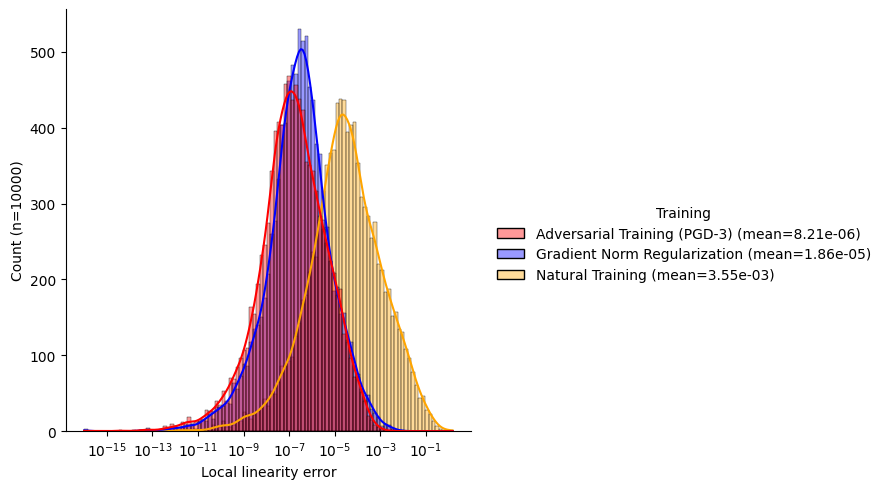

In [51]:
fig = plot_fn(r'Local linearity error', lambda x: x + 1e-16, 
        index=torch.arange(10000), log_scale=(True, False), alpha=0.4)
fig.savefig('./figures_suppmat/local_linearity.pdf', facecolor='white')

In [52]:
def plot_fn(name, fn, *, index=Ellipsis, split=None, **kwargs):
    _at_linerrs = results_dict['advtrain'][index].detach().cpu()
    _gn_strong_linerrs = results_dict['gradnorm_strong'][index].detach().cpu()
    print(_at_linerrs.shape, _gn_strong_linerrs.shape)
    print(_at_linerrs.min(), _gn_strong_linerrs.min())
    if split is None:
        split = _at_linerrs.shape[0]
    at_fn_v = torch.cat([fn(_x) for _x in _at_linerrs.split(split, dim=0)], 0)
    gns_fn_v = torch.cat([fn(_x) for _x in _gn_strong_linerrs.split(split, dim=0)], 0)
    ax = sns.displot(data=pd.DataFrame(
        {
            name: torch.cat([at_fn_v, gns_fn_v], 0).numpy(),
            "Training": (
                ([f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})'] * _at_linerrs.shape[0]) + 
                ([f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})'] * _gn_strong_linerrs.shape[0])
            )
        }), kde=True, x=name, hue='Training', 
        palette = {
            f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})':'red', 
            f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})':'blue',
        }, **kwargs)
    plt.gca().set_ylabel(f'Count (n={_at_linerrs.shape[0]})')
    return ax.fig

torch.Size([10000]) torch.Size([10000])
tensor(0.) tensor(0.)


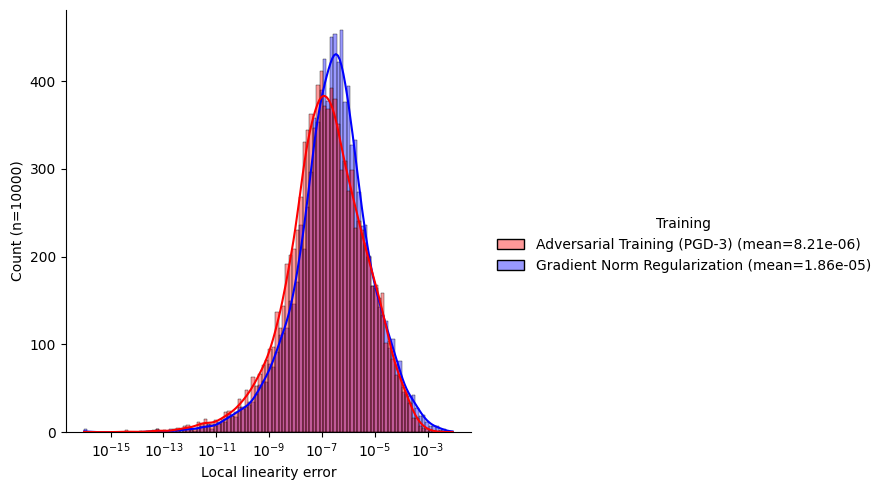

In [53]:
fig = plot_fn(r'Local linearity error', lambda x: x + 1e-16, 
        index=torch.arange(10000), log_scale=(True, False), alpha=0.4)
fig.savefig('./figures_suppmat/local_linearity_nonat.pdf', facecolor='white')